In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

Now we download the data from an online repository

In [2]:
from pymks_share import DataManager

manager = DataManager('pymks.me.gatech.edu')
print manager.list_datasets()
X, y  = manager.fetch_data('random hexagonal orientations')

print X.shape
print y.shape

[u'metallic glass', u'random hexagonal orientations', u'Molecular Dynamics', u'2 phase ising model', u'Etched Low Carbon Steel Optical Micrographs', u'Ising 30%', u'ising 10%', u'Ising 40%_Run#1', u'Ising 40%_Run#2', u'Ising 40%_Run#3']
(50L, 21L, 21L, 21L, 3L)
(50L, 21L, 21L, 21L)


plot a microstructure (phi1 angle only) and response pair

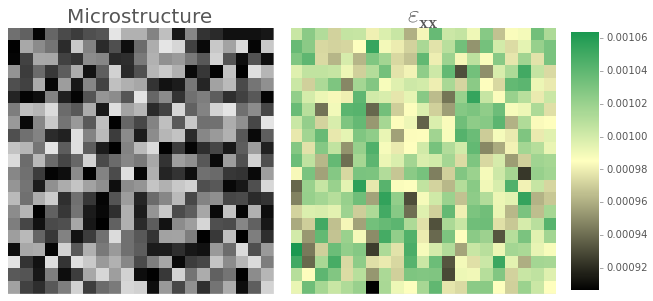

In [3]:
from pymks.tools import draw_microstructure_strain

n = X.shape[1]
center = (n-1) / 2
draw_microstructure_strain(X[0, :, :, center, 0], y[0, :, :,center])


Split the data into calibration and validation sets

In [4]:
X_cal = X[0:40, ...]

print X_cal.shape

X_val = X[40:, ...]
y_cal = y[0:40, ...]
y_val = y[40:, ...]

(40L, 21L, 21L, 21L, 3L)


In [5]:
from pymks import MKSLocalizationModel
from pymks.bases import GSHBasisHexagonal
import pickle

gsh_hex_basis = GSHBasisHexagonal(n_states=15, domain=[-1, 7])

print gsh_hex_basis.discretize(X_cal).shape
pickle.dump(gsh_hex_basis.discretize(X_cal), open('X_GSH_PYMKS.pkl','w'))

model = MKSLocalizationModel(basis=gsh_hex_basis)

(40L, 21L, 21L, 21L, 15L)


In [6]:
print np.min(X_cal), np.max(X_cal)
model.fit(X_cal, y_cal)

-1e-07 6.28318530718


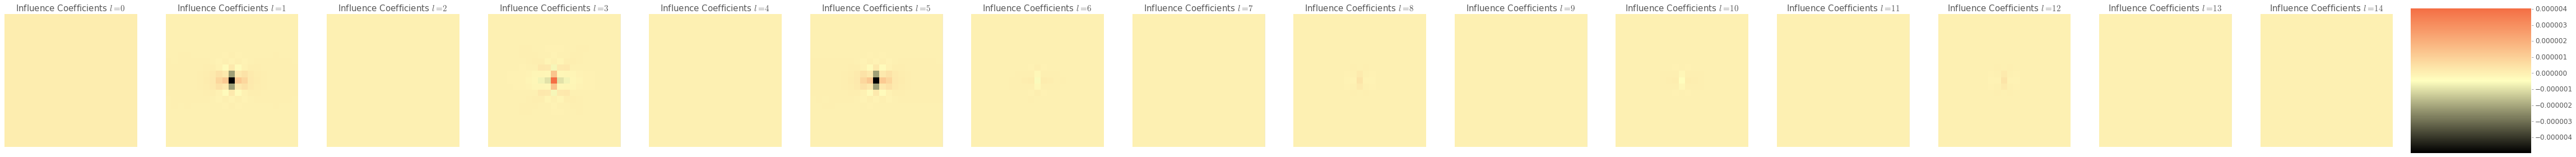

In [7]:
from pymks.tools import draw_coeff

coeff = model.coeff
draw_coeff(np.real(coeff[:,center, :, :]))

In [8]:
y_predict = model.predict(X_val)


ValueError: total size of new array must be unchanged